# Notebook for Lanevin
OBS, this is not a correct run, hence the results presented here are not very good.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy 

from chemprop.features import BatchMolGraph, MolGraph
from chemprop.data.data import MoleculeDatapoint, MoleculeDataset
from chemprop.data import MoleculeDataLoader, split_data
from chemprop.nn_utils import get_activation_function, initialize_weights, NoamLR
import torch
from chemprop.utils import build_lr_scheduler
from torch.nn.parameter import Parameter
td = torch.distributions
from chemprop.args import TrainArgs, HyperoptArgs
from chemprop.features.featurization import get_atom_fdim, get_bond_fdim
from tqdm import tqdm
from chemprop.train import cross_validate, run_training
from chemprop.models.model import LangvianMoleculeModel
from chemprop.features.featurization import BatchMolGraph
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
class BayesianArgs(TrainArgs):
    prior = td.Normal(0,1)
    data_path = "data/freesolv.csv"
    init = 'zeros' # Changed from 'xavier' sometimes produces nans :o
    init_lr = 5e-5#5e-3
    max_lr = 1e-4#1e-2
    final_lr = 1e-10 #1e-4
    train_data_size = 642
    epochs = 1000
    warmup_epochs = 2
    
args = BayesianArgs()
args.ffn_hidden_size = 100
args.hidden_size = 100
args.num_tasks = 1

args.ffn_num_layers = 3
args.depth = 6
args.dropout = 0 # Changed from 0.15
args.num_workers = 0
args.batch_size = 50 # Changed from 50
args.dataset_type = 'regression'
args.device = torch.device('cuda')

/zhome/17/6/118138/anaconda3/envs/chemprop/lib/python3.8/site-packages/tap/tap.py:304: UserWarning: add_arguments is deprecated and will be removed on January 1st, 2021 please override "configure" instead and call add_argument there. 
  warn('add_arguments is deprecated and will be removed on January 1st, 2021'


In [3]:
#!ls
!nvidia-smi
torch.cuda.set_device(3)

Sun Jan  3 20:47:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32C    P0    44W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

In [4]:
#!kill 17877

In [5]:
mod = LangvianMoleculeModel(args)
#mod.load_state_dict(SavedParameters[400])
#mod.load_state_dict(torch.load("F1"))

#mod.load_state_dict(torch.load("3-1-2021_freesolv.pt"))
#mod.load_state_dict(torch.load("freesolv_epochs_2500_epsMIN_1.0E-09_epsMAX_1.0E-06_hidden_100_ffn_num_3_adam2.pt"))

In [7]:
from chemprop.data import get_data
data = get_data(
        path=args.data_path,
        args=args,
        skip_none_targets=True)
train_data, val_data, test_data = split_data(data=data, 
                                             split_type=args.split_type, 
                                             sizes=args.split_sizes, 
                                             seed=args.seed, 
                                             num_folds=args.num_folds, 
                                             args=args, 
                                             logger=None)

642it [00:00, 146027.29it/s]
100%|██████████| 642/642 [00:00<00:00, 9165.16it/s]


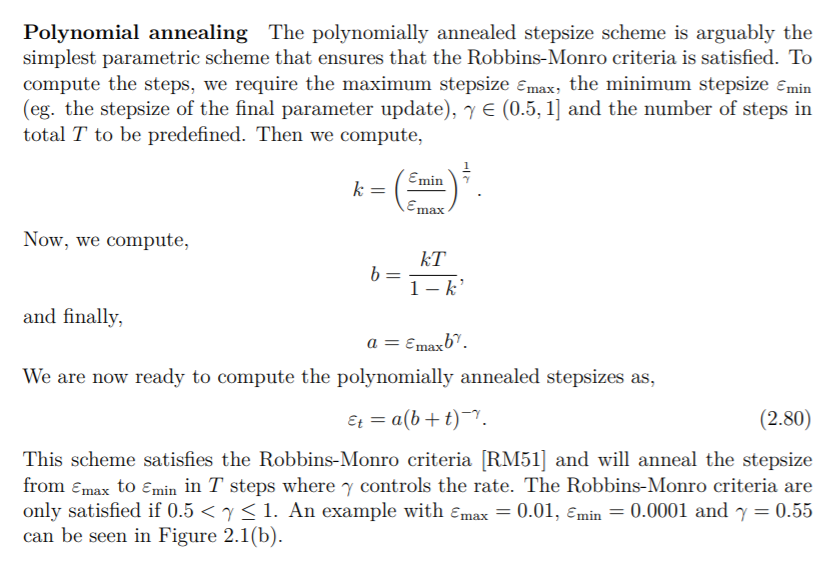

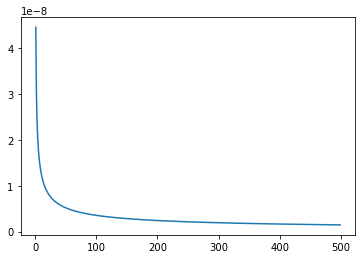

In [8]:
gamma =torch.tensor(0.55)
max_lr = torch.tensor(1.0e-6)
min_lr = torch.tensor(1.0e-9)
T = torch.tensor(args.epochs)

k = (min_lr/max_lr)**(1/gamma)

b = k*T/(1-k)
a = max_lr*b**(gamma)

t_range = np.arange(1, args.epochs/2)
plt.plot(t_range, a * (b + t_range) ** (-gamma))
eps = a * (b + t_range) ** (-gamma)

In [9]:
def train(model: LangvianMoleculeModel,
          data_loader: MoleculeDataLoader,
          optimizer, #Not used. 
          args: TrainArgs,
          n_iter, 
         n_ADAM) -> int:
    """
    Trains a model for an epoch.

    :param model: A :class:`~chemprop.models.model.MoleculeModel`.
    :param data_loader: A :class:`~chemprop.data.data.MoleculeDataLoader`.
    :param loss_func: Loss function.
    :param optimizer: An optimizer.
    :param args: A :class:`~chemprop.args.TrainArgs` object containing arguments for training the model.
    :param n_iter: The number of iterations (training examples) trained on so far.
    :return: The total number of iterations (training examples) trained on so far.
    """
    model.to(device)
    #model.training_mode(True)
    #model.sampling_mode(True)
    model.train()
    loss_sum = iter_count = 0
    num_batches = len(data_loader)
    
    for t, batch in enumerate(tqdm(data_loader, total=len(data_loader), leave=False, disable=True)):
        #print("Iteration", t)
        # Prepare batch
        batch: MoleculeDataset
        mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()
        
        target_batch = torch.Tensor(target_batch)
        target_batch = target_batch.to(device)
        
        # Run model
        model.zero_grad()
        ll = model.sum_ll(mol_batch[0], target_batch) 
        prior_loss = model.prior_loss()
        loss = num_batches*ll + prior_loss
        loss_sum += loss
        
        if torch.isnan(loss): 
            print(ll, prior_loss)
            assert False, "breakpoint"
        
        eps_t = a * (b + t+num_batches*(n_iter-n_ADAM)) ** (-gamma)
        
        if n_iter < n_ADAM: #First epocs are trained using adam. 
            loss = -loss
            loss.backward()
            optimizer.step()

        else: #Langevin step.
            loss.backward(retain_graph=False)
            with torch.no_grad(): #In order to update parameters manually. 
                for name, p in model.named_parameters():
                    #Sample eta hver gang. 
                    if p.grad is not None:
                        eta_t = td.Normal(loc=0, scale=np.sqrt(eps_t)).sample(sample_shape=p.size()).cuda()
                        new_val = p + eps_t/2 * (p.grad) + eta_t
                        p.copy_(new_val)

    return loss_sum / num_batches, eps_t

def get_val_loss(model: LangvianMoleculeModel,
          data_loader: MoleculeDataLoader,
          args: TrainArgs):
    num_batches = len(data_loader)
    loss_sum = 0.0
    
    for b, batch_val in enumerate(tqdm(data_loader, total=len(data_loader), leave=False, disable=True)):
        mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch_val.batch_graph(), batch_val.features(), batch_val.targets(), batch_val.atom_descriptors()
        target_batch = torch.Tensor(target_batch).to(device)
        with torch.no_grad():
            ll = mod.sum_ll(mol_batch[0], target_batch) 
            prior_loss = mod.prior_loss()
            loss = num_batches*ll + prior_loss 
        loss_sum += loss.item()
    return loss_sum / num_batches

In [32]:
device = args.device
epochs = args.epochs
optimizer = torch.optim.Adam(mod.parameters(),lr=args.init_lr) #Only used for checking that manually updating parameters work
scheduler = build_lr_scheduler(optimizer, args)
train_data_loader = MoleculeDataLoader(dataset=train_data,
                                       batch_size=args.batch_size,
                                       num_workers=args.num_workers,
                                       class_balance=args.class_balance,
                                       shuffle=True,
                                       seed=args.seed)
val_data_loader = MoleculeDataLoader(dataset=val_data,batch_size=args.batch_size,num_workers=args.num_workers)
test_data_loader = MoleculeDataLoader(dataset=test_data,batch_size=len(test_data),num_workers=args.num_workers)

num_batches = len(val_data_loader)


SavedParameters = []
n_ADAM = 0

if "loss_lst" or "loss_val" not in globals():
    loss_lst = []
    loss_val = []
    
for n_iter in range(epochs):
    
    loss_sum, eps2 = train(model=mod,
                   data_loader=train_data_loader,
                   optimizer=optimizer,
                   args=args,
                   n_iter=n_iter, 
                    n_ADAM = n_ADAM)
    loss_lst.append(loss_sum)
    
    # Validation 
    mod.eval()
    loss = get_val_loss(mod, val_data_loader, args)
    loss_val.append(loss)

    if n_iter > n_ADAM:
        SavedParameters.append(copy.deepcopy(mod.state_dict()))
    
    print(f"Epoch {n_iter+1} loss {loss_sum}, val loss {loss}, eta std {np.sqrt(eps2)}")

Epoch 1 loss -72990.15625, val loss -72639.59375, eta std 0.00011219112639082596
Epoch 2 loss -72626.765625, val loss -72640.08203125, eta std 9.148927347268909e-05
Epoch 3 loss -72618.5390625, val loss -72640.62109375, eta std 8.14837621874176e-05
Epoch 4 loss -72618.703125, val loss -72642.6015625, eta std 7.512541196774691e-05
Epoch 5 loss -72615.703125, val loss -72636.75390625, eta std 7.056419417494908e-05
Epoch 6 loss -72622.640625, val loss -72636.39453125, eta std 6.705679697915912e-05
Epoch 7 loss -72619.7265625, val loss -72633.02734375, eta std 6.423491868190467e-05
Epoch 8 loss -72616.9140625, val loss -72640.18359375, eta std 6.189104897202924e-05
Epoch 9 loss -72613.3828125, val loss -72638.84375, eta std 5.9897542087128386e-05
Epoch 10 loss -72614.1015625, val loss -72641.95703125, eta std 5.817070268676616e-05
Epoch 11 loss -72615.6875, val loss -72639.4375, eta std 5.6652894272701815e-05
Epoch 12 loss -72612.8046875, val loss -72632.80859375, eta std 5.530286580324173

Epoch 99 loss -72611.3125, val loss -72657.27734375, eta std 3.0897768738213927e-05
Epoch 100 loss -72610.53125, val loss -72659.78125, eta std 3.0812410841463134e-05
Epoch 101 loss -72613.078125, val loss -72658.15234375, eta std 3.0728137062396854e-05
Epoch 102 loss -72613.328125, val loss -72656.43359375, eta std 3.064491829718463e-05
Epoch 103 loss -72612.765625, val loss -72650.54296875, eta std 3.0562739993911237e-05
Epoch 104 loss -72611.875, val loss -72648.8125, eta std 3.048157122975681e-05
Epoch 105 loss -72611.71875, val loss -72649.66796875, eta std 3.040139017684851e-05
Epoch 106 loss -72611.5390625, val loss -72649.96875, eta std 3.0322182283271104e-05
Epoch 107 loss -72611.828125, val loss -72649.22265625, eta std 3.024391844519414e-05
Epoch 108 loss -72611.3359375, val loss -72649.70703125, eta std 3.0166584110702388e-05
Epoch 109 loss -72612.859375, val loss -72651.9921875, eta std 3.0090157451923005e-05
Epoch 110 loss -72610.953125, val loss -72650.0859375, eta std 3

Epoch 196 loss -72606.875, val loss -72640.3828125, eta std 2.560367101978045e-05
Epoch 197 loss -72607.5859375, val loss -72637.9921875, eta std 2.5567847842467017e-05
Epoch 198 loss -72607.4375, val loss -72641.56640625, eta std 2.5532255676807836e-05
Epoch 199 loss -72606.765625, val loss -72640.08203125, eta std 2.5496890884824097e-05
Epoch 200 loss -72607.359375, val loss -72640.73828125, eta std 2.5461753466515802e-05
Epoch 201 loss -72607.125, val loss -72640.5859375, eta std 2.542683796491474e-05
Epoch 202 loss -72607.6015625, val loss -72641.14453125, eta std 2.539214438002091e-05
Epoch 203 loss -72607.0859375, val loss -72639.3671875, eta std 2.5357669073855504e-05
Epoch 204 loss -72608.109375, val loss -72638.30859375, eta std 2.5323410227429122e-05
Epoch 205 loss -72609.625, val loss -72640.27734375, eta std 2.5289364202762954e-05
Epoch 206 loss -72610.0703125, val loss -72643.4921875, eta std 2.5255529180867597e-05
Epoch 207 loss -72609.421875, val loss -72641.81640625, et

Epoch 292 loss -72608.0390625, val loss -72639.39453125, eta std 2.294426849402953e-05
Epoch 293 loss -72610.375, val loss -72637.4375, eta std 2.2922700736671686e-05
Epoch 294 loss -72609.9140625, val loss -72639.90625, eta std 2.2901225747773424e-05
Epoch 295 loss -72609.046875, val loss -72639.57421875, eta std 2.2879843527334742e-05
Epoch 296 loss -72608.3828125, val loss -72640.95703125, eta std 2.285855407535564e-05
Epoch 297 loss -72607.5625, val loss -72639.828125, eta std 2.283735739183612e-05
Epoch 298 loss -72608.7421875, val loss -72640.10546875, eta std 2.281625165778678e-05
Epoch 299 loss -72609.5234375, val loss -72640.41015625, eta std 2.2795233235228807e-05
Epoch 300 loss -72609.078125, val loss -72640.734375, eta std 2.2774307581130415e-05
Epoch 301 loss -72608.3828125, val loss -72639.890625, eta std 2.275346741953399e-05
Epoch 302 loss -72609.7890625, val loss -72639.55859375, eta std 2.2732718207407743e-05
Epoch 303 loss -72608.9296875, val loss -72640.96484375, et

Epoch 389 loss -72613.9609375, val loss -72650.44140625, eta std 2.12035756703699e-05
Epoch 390 loss -72614.46875, val loss -72652.29296875, eta std 2.1188607206568122e-05
Epoch 391 loss -72613.609375, val loss -72652.33203125, eta std 2.117368785548024e-05
Epoch 392 loss -72612.7265625, val loss -72650.8984375, eta std 2.1158815798116848e-05
Epoch 393 loss -72612.234375, val loss -72649.59375, eta std 2.1143992853467353e-05
Epoch 394 loss -72613.71875, val loss -72646.390625, eta std 2.1129219021531753e-05
Epoch 395 loss -72614.953125, val loss -72645.99609375, eta std 2.1114492483320646e-05
Epoch 396 loss -72615.078125, val loss -72644.859375, eta std 2.1099811419844627e-05
Epoch 397 loss -72615.9375, val loss -72644.7734375, eta std 2.1085179469082505e-05
Epoch 398 loss -72614.453125, val loss -72647.12109375, eta std 2.107059299305547e-05
Epoch 399 loss -72614.203125, val loss -72646.30859375, eta std 2.1056053810752928e-05
Epoch 400 loss -72614.6171875, val loss -72648.1015625, et

Epoch 485 loss -72617.640625, val loss -72663.62109375, eta std 1.9955416064476594e-05
Epoch 486 loss -72615.953125, val loss -72666.28125, eta std 1.994411286432296e-05
Epoch 487 loss -72615.546875, val loss -72666.796875, eta std 1.9932838767999783e-05
Epoch 488 loss -72615.8046875, val loss -72664.54296875, eta std 1.992159741348587e-05
Epoch 489 loss -72616.640625, val loss -72666.48046875, eta std 1.991038334381301e-05
Epoch 490 loss -72616.4140625, val loss -72667.328125, eta std 1.9899198377970606e-05
Epoch 491 loss -72617.6640625, val loss -72668.21484375, eta std 1.9888044334948063e-05
Epoch 492 loss -72616.875, val loss -72665.26953125, eta std 1.9876917576766573e-05
Epoch 493 loss -72617.34375, val loss -72666.88671875, eta std 1.986581992241554e-05
Epoch 494 loss -72618.0, val loss -72668.17578125, eta std 1.985474955290556e-05
Epoch 495 loss -72617.5390625, val loss -72666.03515625, eta std 1.984371010621544e-05
Epoch 496 loss -72617.3046875, val loss -72666.51171875, eta 

Epoch 582 loss -72607.7109375, val loss -72669.12109375, eta std 3.2542480767006055e-05
Epoch 583 loss -72608.6484375, val loss -72663.1875, eta std 3.2434065360575914e-05
Epoch 584 loss -72607.140625, val loss -72661.36328125, eta std 3.2327305234503e-05
Epoch 585 loss -72606.9140625, val loss -72662.44921875, eta std 3.222215309506282e-05
Epoch 586 loss -72606.1328125, val loss -72664.1484375, eta std 3.211857256246731e-05
Epoch 587 loss -72607.4765625, val loss -72665.4140625, eta std 3.201651634299196e-05
Epoch 588 loss -72607.109375, val loss -72666.06640625, eta std 3.191594441886991e-05
Epoch 589 loss -72606.4921875, val loss -72663.30859375, eta std 3.1816820410313085e-05
Epoch 590 loss -72607.4921875, val loss -72664.5703125, eta std 3.1719111575512215e-05
Epoch 591 loss -72607.875, val loss -72664.62109375, eta std 3.162277789670043e-05
Epoch 592 loss -72609.40625, val loss -72660.3203125, eta std 3.152778299408965e-05
Epoch 593 loss -72607.0234375, val loss -72663.19140625, 

Epoch 678 loss -72613.359375, val loss -72689.88671875, eta std 2.629133996379096e-05
Epoch 679 loss -72613.46875, val loss -72686.06640625, eta std 2.6250845621689223e-05
Epoch 680 loss -72612.71875, val loss -72687.97265625, eta std 2.6210638679913245e-05
Epoch 681 loss -72612.953125, val loss -72690.92578125, eta std 2.6170717319473624e-05
Epoch 682 loss -72614.25, val loss -72693.90234375, eta std 2.6131074264412746e-05
Epoch 683 loss -72613.4140625, val loss -72694.015625, eta std 2.609170951473061e-05
Epoch 684 loss -72614.703125, val loss -72695.55078125, eta std 2.6052615794469602e-05
Epoch 685 loss -72614.5625, val loss -72696.70703125, eta std 2.6013794922619127e-05
Epoch 686 loss -72615.40625, val loss -72695.73046875, eta std 2.597523962322157e-05
Epoch 687 loss -72614.8515625, val loss -72696.2265625, eta std 2.5936948077287525e-05
Epoch 688 loss -72615.7734375, val loss -72697.09375, eta std 2.5898916646838188e-05
Epoch 689 loss -72614.890625, val loss -72696.6640625, eta

Epoch 774 loss -72617.5390625, val loss -72684.796875, eta std 2.3349388357019052e-05
Epoch 775 loss -72617.5703125, val loss -72682.84765625, eta std 2.3326001610257663e-05
Epoch 776 loss -72617.3203125, val loss -72683.66796875, eta std 2.330272036488168e-05
Epoch 777 loss -72618.1015625, val loss -72689.109375, eta std 2.327954825886991e-05
Epoch 778 loss -72617.125, val loss -72685.0546875, eta std 2.3256481654243544e-05
Epoch 779 loss -72618.6484375, val loss -72685.71484375, eta std 2.3233522369991988e-05
Epoch 780 loss -72617.8203125, val loss -72687.01171875, eta std 2.3210668587125838e-05
Epoch 781 loss -72617.640625, val loss -72690.46875, eta std 2.3187916667666286e-05
Epoch 782 loss -72617.46875, val loss -72689.625, eta std 2.3165268430602737e-05
Epoch 783 loss -72616.1796875, val loss -72690.24609375, eta std 2.3142720237956382e-05
Epoch 784 loss -72617.703125, val loss -72693.18359375, eta std 2.312027572770603e-05
Epoch 785 loss -72617.8203125, val loss -72688.0625, eta

Epoch 870 loss -72620.828125, val loss -72680.7890625, eta std 2.1497660782188177e-05
Epoch 871 loss -72622.1015625, val loss -72682.546875, eta std 2.1481706426129676e-05
Epoch 872 loss -72622.140625, val loss -72680.0546875, eta std 2.1465806639753282e-05
Epoch 873 loss -72621.765625, val loss -72681.30859375, eta std 2.1449961423058994e-05
Epoch 874 loss -72621.765625, val loss -72679.80859375, eta std 2.1434170776046813e-05
Epoch 875 loss -72622.28125, val loss -72682.296875, eta std 2.1418432879727334e-05
Epoch 876 loss -72620.8125, val loss -72683.22265625, eta std 2.140274955308996e-05
Epoch 877 loss -72619.5703125, val loss -72685.34375, eta std 2.1387118977145292e-05
Epoch 878 loss -72620.640625, val loss -72684.62109375, eta std 2.137153933290392e-05
Epoch 879 loss -72619.4765625, val loss -72682.5390625, eta std 2.1356014258344658e-05
Epoch 880 loss -72619.3984375, val loss -72680.08203125, eta std 2.1340541934478097e-05
Epoch 881 loss -72619.265625, val loss -72680.87890625

Epoch 966 loss -72618.5703125, val loss -72686.0234375, eta std 2.017597398662474e-05
Epoch 967 loss -72618.4765625, val loss -72686.359375, eta std 2.0164081433904357e-05
Epoch 968 loss -72618.75, val loss -72685.42578125, eta std 2.0152221622993238e-05
Epoch 969 loss -72618.3125, val loss -72682.53125, eta std 2.0140394553891383e-05
Epoch 970 loss -72619.2265625, val loss -72679.546875, eta std 2.0128600226598792e-05
Epoch 971 loss -72618.375, val loss -72680.99609375, eta std 2.0116835003136657e-05
Epoch 972 loss -72617.9453125, val loss -72680.9921875, eta std 2.0105102521483786e-05
Epoch 973 loss -72618.2890625, val loss -72680.44921875, eta std 2.009340278164018e-05
Epoch 974 loss -72619.6953125, val loss -72681.58984375, eta std 2.0081733964616433e-05
Epoch 975 loss -72619.609375, val loss -72684.5234375, eta std 2.0070096070412546e-05
Epoch 976 loss -72618.953125, val loss -72684.84765625, eta std 2.0058490918017924e-05
Epoch 977 loss -72618.8125, val loss -72685.2578125, eta s

Text(0.5, 1.0, 'Freesolv')

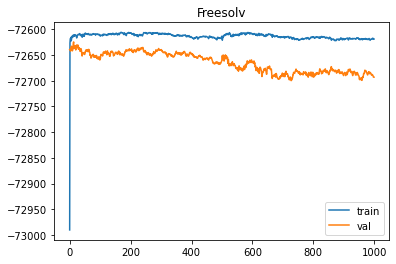

In [37]:
plt.clf()
plt.plot(np.asarray(loss_lst[0:]))
plt.plot(np.asarray(loss_val[0:]))
plt.legend(['train', 'val'])
plt.title("Freesolv")

## Sample from posterior (i.e. get latest weights in SavedParameters)

In [43]:
batch = next(iter(test_data_loader)) #All data
mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()

y2_pred_mean = [] #Size (S, N_test)  
y2_pred_std =  [] #Size (S, N_test)

for i in range(len(SavedParameters)-900, len(SavedParameters)):
    mod.load_state_dict(SavedParameters[i])
    y_pred_mean, y_pred_rho = mod.forward(mol_batch[0])
    y_pred_mean = y_pred_mean.detach()
    y_pred_rho = y_pred_rho.detach()
    y_pred_std =  mod.softplus(y_pred_rho) + mod.eps
    
    y2_pred_mean.append(y_pred_mean)
    y2_pred_std.append(y_pred_std)

## Functions for plotting output distribution

In [44]:
from scipy.stats import norm

def PlotFunction(par, amount):

    fig=plt.figure(figsize=(16, 64))
    fig.tight_layout()


    columns = 2
    rows = 32
    for index in range(amount):
        y1 = []
        y2 = []
        for i in range(len(y2_pred_std)):
            y1.append(y2_pred_mean[i][index][par].item())
            y2.append(y2_pred_std[i][index][par].item())

        if index == 0:
            ax1 = fig.add_subplot(rows, columns, index+1)
        else:
            fig.add_subplot(rows, columns, index+1, sharex = None)

        yytest = np.array(target_batch[index][par])
        plt.hist(y1, bins = 20,weights=[1/50]*len(y1),color='black',alpha = 0.5 )
        plt.axvline(x=yytest, color='r', linestyle='dashed', linewidth=2)

        x_axis = np.arange(min(min(y1),yytest)-0.1,max(max(y1),yytest)+0.1 , 0.001)

        for i in range(len(y2_pred_std)):
            STD = np.sqrt(np.std(y1, axis=0)**2+np.mean(np.array(y2)**2)) 
            RMSE = np.sqrt(np.mean((y1-yytest)**2))

            p2 = plt.plot(x_axis, norm.pdf(x_axis,y1[i],y2[i]), 'b-',alpha = 0.03, label = "$\sqrt{E(\sigma^2)}$"+f" {STD:.2f} \nRMSE  {RMSE:.2f}\nIndex {index}")

        plt.legend(handles = p2,loc='upper left')

    plt.show()

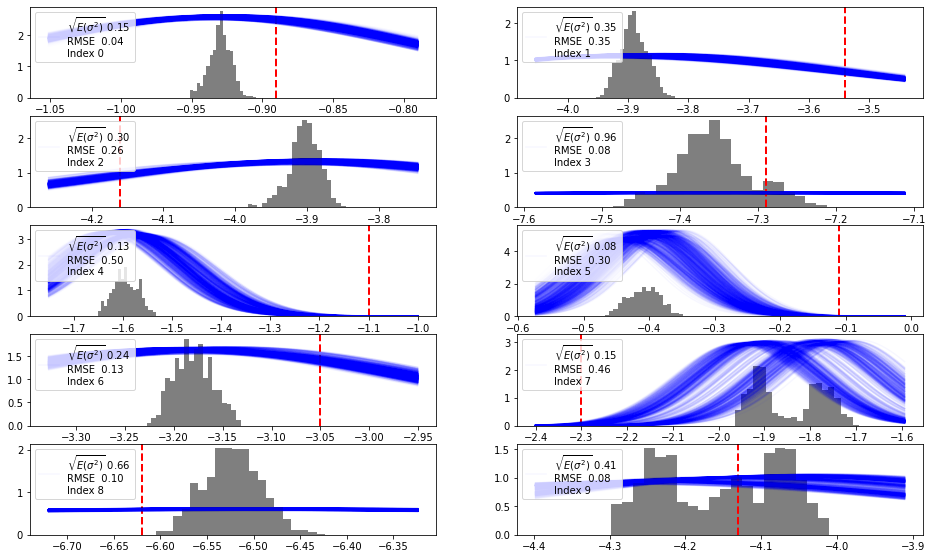

In [45]:
PlotFunction(0,10)

## Uncertainty quantification quality test (Calibration measure)

### Functions

In [46]:
def ENCE(sigma, rmse):
    return np.mean(np.abs(sigma - rmse) / sigma)

def plot_error_calibration(y_pred, y_std, title):
    sort_index = np.argsort(y_std)
    y_test_ = y_test[sort_index]
    y_pred_ = y_pred[sort_index]
    y_std_ = y_std[sort_index]
    aggregate_every = 6
    rmse = np.empty((len(test_data) // aggregate_every))
    sigma = np.empty((len(test_data) // aggregate_every))

    for i in range(len(test_data) // aggregate_every):
        y_test_agr = y_test_[i*aggregate_every:(i+1)*aggregate_every]
        y_pred_agr = y_pred_[i*aggregate_every:(i+1)*aggregate_every]
        y_std_agr  = y_std_[i*aggregate_every:(i+1)*aggregate_every]

        sigma[i] = np.mean(y_std_agr)
        rmse[i] = np.sqrt(np.mean((y_pred_agr - y_test_agr)**2))
    ence = ENCE(sigma, rmse)
    
    
    x = np.linspace(np.min(rmse),np.max(rmse),100)
    y = x
    plt.plot(x, y, '--')
    plt.plot(sigma, rmse, 'b+')
    plt.xlabel('$\sqrt{E(\sigma^2)}$')
    plt.ylabel('RMSE')
    plt.tight_layout()
    plt.axis('equal')
    plt.text(np.max(rmse) - 0.02, 0.075, f'ENCE = {round(ence, 3)}',
        verticalalignment='bottom', horizontalalignment='right',
        color='blue', fontsize=15)
    plt.title(title)
    plt.show()
    
def plot_coverage(y_pred_s, title):
    pred_ints = np.linspace(0, 1, 100)[1:]
    y_test = np.array(target_batch)
    icp = []
    for pred_int in pred_ints:
        p_upper = 1 - (1-pred_int)/2
        p_lower = p_upper - pred_int
        q1 = np.quantile(y_pred_s, p_lower, axis=0)
        q2 = np.quantile(y_pred_s, p_upper, axis=0)

        icp.append(np.mean(np.logical_and(y_test.squeeze() < q2, y_test.squeeze() > q1)))
    
    x_perf = np.linspace(0, 1, 1000)
    plt.plot(x_perf, x_perf)
    plt.plot(icp, pred_ints)
    plt.xlabel('Estimated Interval Coverage')
    plt.ylabel('Prediction Interval')
    plt.axis('equal')
    plt.title(title)
    plt.show()

### calibration results

In [47]:
y_test =np.array([target_batch[i] for i in range(len(target_batch))])
y_std = np.array([[ np.squeeze(y2_pred_std[i][index].cpu().numpy()) for i in range(len(y2_pred_std))] for index in range(len(y_test))])
y_pred = np.array([[ np.squeeze(y2_pred_mean[i][index].cpu().numpy()) for i in range(len(y2_pred_std))] for index in range(len(y_test))])

In [48]:
print(f"Saving Freesolv posterior samples as txt files")

#np.savetxt(f'LangevinResults/langevin_mean_Freesolv.txt', y_pred) 
#np.savetxt(f'LangevinResults/langevin_std_Freesolv.txt', y_std) 
#np.savetxt(f'LangevinResults/langevin_test_Freesolv.txt', y_test)

Saving Freesolv posterior samples as txt files


In [49]:
Langevin_pred=y_pred# np.loadtxt('langevin_mean.txt')#y_pred#
Langevin_std=y_std # np.loadtxt('langevin_std.txt') #y_std#
#y_test = np.loadtxt('langevin_test.txt')
Langevin_pred = Langevin_pred.T
Langevin_std = Langevin_std.T

y_pred = np.mean(Langevin_pred, axis=0) #
y_var_epi = np.std(Langevin_pred, axis=0)**2 #epistemisk
y_var_ale = np.mean(Langevin_std**2, axis=0) #aleatroisk

y_std = np.sqrt(y_var_epi+y_var_ale)

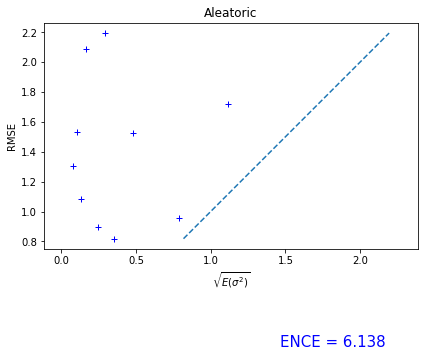

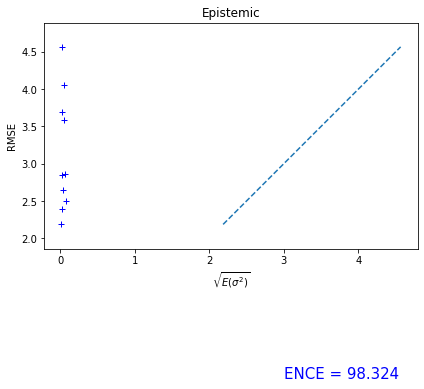

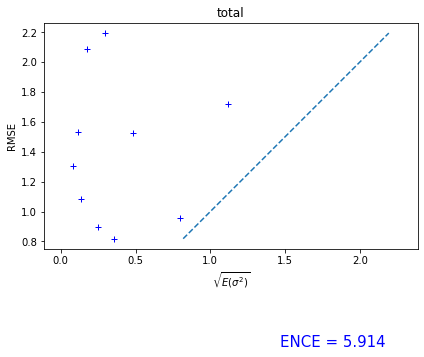

In [50]:
plot_error_calibration(y_pred, np.sqrt(y_var_ale), title='Aleatoric')
plot_error_calibration(y_pred, np.sqrt(y_var_epi), title='Epistemic')
plot_error_calibration(y_pred, y_std, title='total')

In [51]:
S=len(Langevin_pred)
y_pred_s_lang = np.empty((S, len(test_data)))
for s in range(S):
    y_pred_s_lang[s] = np.random.normal(Langevin_pred[s], Langevin_std[s])

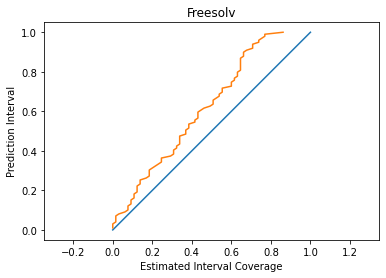

In [52]:
S=len(Langevin_pred)
y_pred_s_lang = np.empty((S, len(test_data)))
for s in range(S):
    y_pred_s_lang[s] = np.random.normal(Langevin_pred[s], Langevin_std[s])

plot_coverage(y_pred_s_lang, f"Freesolv")